import numpy as np
import scipy as sp
from statsmodels.stats.power import NormalIndPower




In [7]:
effect_size = 0.380101341 / 0.261796652    # delta(log odds) / pooled standard error
n_1 = 29+20+1377+13820                     # n 
n_2 = 209+299+1406+13840

In [8]:
pwr = NormalIndPower()
pwr.power(effect_size=effect_size, nobs1=n_1, alpha=0.05, ratio=n_2/n_1)

1.0

In [10]:
pwr.solve_power(effect_size = None, nobs1=n_1, alpha=0.05, ratio=n_2/n_1, power=0.8)

0.031826898474489454

In [3]:
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection as fdr

In [4]:

dfs = []
for value in ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Insulin Disorders", "Diabetes"]:
    dfs.append(pd.read_csv("../statistical_dump/{}_ors_mko.tsv".format(value), sep="\t", header=0))




In [5]:
df = dfs[0]

In [29]:
pwr = NormalIndPower()
#pwr.power(effect_size=effect_size, nobs1=n_1, alpha=0.05, ratio=n_2/n_1)

In [1]:
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection as fdr
import numpy as np
import scipy.stats as stats
methods = ["FiLM", "TAG", "GCN", "N2V+MLP", "MLP"]
diseases = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Insulin Disorders", "Diabetes"]
outer_dfs = []
global_pvals = []
for value in diseases:
    results_df = pd.DataFrame(columns=["Mendelian/Method", "CS", "log odds", "a", "b", "c", "d", "se", "delta_log_odds (C-M)", "se_delta", "Z", "pval unadjusted", "pval adjusted (FDR)", "result"])
    df= pd.read_csv("../statistical_dump/{}_ors_mko.tsv".format(value), sep="\t", header=0)
    method_list = ["Mendelian"]
    cs_list = ["-"]
    log_odds = []
    a_list = []
    b_list = []
    c_list = []
    d_list = []
    se_list = []
    delta_log_odds_list = [np.nan]
    se_delta_list = [np.nan]
    zval_list = [np.nan]
    pval_list = [np.nan]
    result_list = ["-"]

    need_set_mendelians = True
    for method in methods:
        method_list.append(method)
        cs = 12
        significant = False

        a = "N Candidate/Mendelian and MKO"
        b = "N Candidate/Mendelian not MKO"
        c = "N Not Candidate/Mendelian and MKO"
        d = "N Not Candidate/Mendelian Not MKO"
        pval = "pval adjusted (FDR)"

        while not significant:
            cs -= 1
            candidate_row = df[(df["Method"] == method) & (df["CS/Mendelian"] == "CS >= {}".format(cs))]
            significant = candidate_row[pval].item() < 0.05

        cs_list.append(cs)

        mendelian_row = df.iloc[11]

        log_odds_candidates = np.log(candidate_row["OR"].item())
        log_odds_mendelians = np.log(mendelian_row["OR"].item())
        delta = log_odds_candidates - log_odds_mendelians

        var_candidates = np.sum([1 / candidate_row[column] for column in [a, b, c, d]])
        var_mendelian = np.sum([1 / mendelian_row[column] for column in [a, b, c, d]])

        if need_set_mendelians:
            log_odds.append(log_odds_mendelians)
            a_list.append(mendelian_row[a].item())
            b_list.append(mendelian_row[b].item())
            c_list.append(mendelian_row[c].item())
            d_list.append(mendelian_row[d].item())
            se_list.append(np.sqrt(var_mendelian))
            need_set_mendelians = False

        log_odds.append(log_odds_candidates)
        a_list.append(candidate_row[a].item())
        b_list.append(candidate_row[b].item())
        c_list.append(candidate_row[c].item())
        d_list.append(candidate_row[d].item())
        se_list.append(np.sqrt(var_candidates))

        n1 = np.sum([candidate_row[column] for column in [a, b, c, d]])
        n2 = np.sum([mendelian_row[column] for column in [a, b, c, d]])

        se_delta = np.sqrt(var_candidates + var_mendelian)
        zval = delta / se_delta
        pval = stats.norm.sf(np.abs(zval)) * 2

        delta_log_odds_list.append(delta)
        se_delta_list.append(se_delta)
        zval_list.append(zval)
        pval_list.append(pval)

    results_df["Mendelian/Method"] =  method_list
    results_df["CS"] = cs_list
    results_df["log odds"] = log_odds
    results_df["a"] = a_list
    results_df["b"] = b_list
    results_df["c"] = c_list
    results_df["d"] = d_list
    results_df["se"] = se_list
    results_df["delta_log_odds (C-M)"] = delta_log_odds_list
    results_df["se_delta"] = se_delta_list
    results_df["Z"] = zval_list
    results_df["pval unadjusted"] = pval_list
    #print("{}: CS >= {}: {}".format(method, cs, result))
    #print("Power: {}".format(pwr.power(effect_size=zval, nobs1=n1, alpha=0.05, ratio=n2/n1)))
    #print("Pval: {}".format(pval))
    outer_dfs.append(results_df)
    global_pvals.extend(np.asarray(pval_list)[~np.isnan(pval_list)])

/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in long_scalars


In [4]:
results_df

,Mendelian/Method,CS,log odds,a,b,c,d,se,delta_log_odds (C-M),se_delta,Z,pval unadjusted,pval adjusted (FDR),result
0,GWAS,-,NaN,0,0,719,13822,inf,NaN,NaN,NaN,NaN,NaN,NaN
1,FiLM,8,1.104594,5,32,714,13790,0.482414,NaN,inf,NaN,NaN,NaN,NaN
2,TAG,6,0.910273,10,78,709,13744,0.338088,NaN,inf,NaN,NaN,NaN,NaN
3,GCN,11,2.452986,6,10,713,13812,0.517824,NaN,inf,NaN,NaN,NaN,NaN
4,N2V+MLP,11,1.680828,5,18,714,13804,0.506980,NaN,inf,NaN,NaN,NaN,NaN
5,MLP,10,0.777488,12,107,707,13715,0.306866,NaN,inf,NaN,NaN,NaN,NaN


In [19]:
print(np.sum(np.asarray(global_pvals) < 0.05))

pvals_adj = fdr(global_pvals)[1]

(np.sum(np.asarray(pvals_adj) < 0.05))


15


13

In [20]:
for df, df_pvals_adj, disease in zip(outer_dfs, np.array_split(pvals_adj, len(outer_dfs)), diseases):
    print(len(df))
    print(df_pvals_adj)
    df.loc[~np.isnan(df["pval unadjusted"]), "pval adjusted (FDR)"] = df_pvals_adj
    result = []
    zvals = df.loc[~np.isnan(df["pval unadjusted"]), "Z"]
    for pval, zval in zip(df_pvals_adj, zvals):
        if pval < 0.05:
            if zval < 0:
                result.append("less")
            else:
                result.append("greater")
        else:
            result.append("equal")
    df.loc[~np.isnan(df["pval unadjusted"]), "result"] = result

    df.to_csv("../statistical_dump/{}_difference_gwas.tsv".format(disease), sep="\t", index=False)

    

6
[0.05901276 0.00050454 0.09131208 0.01669394 0.18649947]
6
[6.55189216e-06 7.03673346e-07 2.01962254e-02 5.23222836e-07
 2.01962254e-02]
6
[0.12479901 0.02019623 0.0394252  0.0011041  0.05901276]
6
[5.04542114e-04 8.30646579e-01 9.13120847e-02 2.05650803e-01
 5.82914398e-01]
6
[0.13350469 0.12479901 0.00032639 0.02019623 0.17821412]


In [7]:
df.head()

,Mendelian/Method,CS,log odds,a,b,c,d,se,delta_log_odds (C-M),se_delta,Z,pval unadjusted,pval adjusted (FDR),result
0,Mendelian,-,2.560246,70,104,719,13822,0.159262,NaN,NaN,NaN,NaN,NaN,NaN
1,FiLM,8,1.104594,5,32,714,13790,0.482414,-1.455652,0.508023,-2.865326,0.004166,0.013018,less
2,TAG,6,0.910273,10,78,709,13744,0.338088,-1.649973,0.373722,-4.414978,0.000010,0.000063,less
3,GCN,11,2.452986,6,10,713,13812,0.517824,-0.107260,0.541762,-0.197984,0.843058,0.874897,equal
4,N2V+MLP,11,1.680828,5,18,714,13804,0.506980,-0.879418,0.531406,-1.654888,0.097947,0.14404,equal


In [17]:
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection as fdr
import numpy as np
import scipy.stats as stats
methods = ["FiLM", "TAG", "GCN", "N2V+MLP", "MLP"]
diseases = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Insulin Disorders", "Diabetes"]
outer_dfs = []
global_pvals = []
for value in diseases:
    results_df = pd.DataFrame(columns=["GWAS/Method", "CS", "log odds", "a", "b", "c", "d", "se", "delta_log_odds (C-G)", "se_delta", "Z", "pval unadjusted", "pval adjusted (FDR)", "result"])
    df= pd.read_csv("../statistical_dump/{}_ors_mko_gwas.tsv".format(value), sep="\t", header=0)
    method_list = ["GWAS"]
    cs_list = ["-"]
    log_odds = []
    a_list = []
    b_list = []
    c_list = []
    d_list = []
    se_list = []
    delta_log_odds_list = [np.nan]
    se_delta_list = [np.nan]
    zval_list = [np.nan]
    pval_list = [np.nan]
    result_list = ["-"]

    need_set_mendelians = True
    for method in methods:
        method_list.append(method)
        cs = 12
        significant = False

        a = "N Candidate/Mendelian and MKO"
        b = "N Candidate/Mendelian not MKO"
        c = "N Not Candidate/Mendelian and MKO"
        d = "N Not Candidate/Mendelian Not MKO"
        pval = "pval adjusted (FDR)"

        while not significant:
            cs -= 1
            candidate_row = df[(df["Method"] == method) & (df["CS/Mendelian"] == "CS >= {}".format(cs))]
            significant = candidate_row[pval].item() < 0.05

        cs_list.append(cs)

        mendelian_row = df.iloc[0]

        log_odds_candidates = np.log(candidate_row["OR"].item())
        log_odds_mendelians = np.log(mendelian_row["OR"].item())
        delta = log_odds_candidates - log_odds_mendelians

        var_candidates = np.sum([1 / candidate_row[column] for column in [a, b, c, d]])
        var_mendelian = np.sum([1 / mendelian_row[column] for column in [a, b, c, d]])

        if need_set_mendelians:
            log_odds.append(log_odds_mendelians)
            a_list.append(mendelian_row[a].item())
            b_list.append(mendelian_row[b].item())
            c_list.append(mendelian_row[c].item())
            d_list.append(mendelian_row[d].item())
            se_list.append(np.sqrt(var_mendelian))
            need_set_mendelians = False

        log_odds.append(log_odds_candidates)
        a_list.append(candidate_row[a].item())
        b_list.append(candidate_row[b].item())
        c_list.append(candidate_row[c].item())
        d_list.append(candidate_row[d].item())
        se_list.append(np.sqrt(var_candidates))

        n1 = np.sum([candidate_row[column] for column in [a, b, c, d]])
        n2 = np.sum([mendelian_row[column] for column in [a, b, c, d]])

        se_delta = np.sqrt(var_candidates + var_mendelian)
        zval = delta / se_delta
        pval = stats.norm.sf(np.abs(zval)) * 2

        delta_log_odds_list.append(delta)
        se_delta_list.append(se_delta)
        zval_list.append(zval)
        pval_list.append(pval)

    results_df["GWAS/Method"] =  method_list
    results_df["CS"] = cs_list
    results_df["log odds"] = log_odds
    results_df["a"] = a_list
    results_df["b"] = b_list
    results_df["c"] = c_list
    results_df["d"] = d_list
    results_df["se"] = se_list
    results_df["delta_log_odds (C-G)"] = delta_log_odds_list
    results_df["se_delta"] = se_delta_list
    results_df["Z"] = zval_list
    results_df["pval unadjusted"] = pval_list
    #print("{}: CS >= {}: {}".format(method, cs, result))
    #print("Power: {}".format(pwr.power(effect_size=zval, nobs1=n1, alpha=0.05, ratio=n2/n1)))
    #print("Pval: {}".format(pval))
    outer_dfs.append(results_df)
    global_pvals.extend(np.asarray(pval_list)[~np.isnan(pval_list)])

In [18]:
results_df

,GWAS/Method,CS,log odds,a,b,c,d,se,delta_log_odds (C-G),se_delta,Z,pval unadjusted,pval adjusted (FDR),result
0,GWAS,-,0.303063,84,1126,705,12800,0.119538,NaN,NaN,NaN,NaN,NaN,NaN
1,FiLM,8,1.104594,5,32,714,13790,0.482414,0.801531,0.497004,1.612727,0.106804,NaN,NaN
2,TAG,6,0.910273,10,78,709,13744,0.338088,0.607209,0.358599,1.693283,0.090402,NaN,NaN
3,GCN,11,2.452986,6,10,713,13812,0.517824,2.149923,0.531442,4.045448,0.000052,NaN,NaN
4,N2V+MLP,11,1.680828,5,18,714,13804,0.506980,1.377765,0.520882,2.645061,0.008168,NaN,NaN
5,MLP,10,0.777488,12,107,707,13715,0.306866,0.474425,0.329326,1.440592,0.149700,NaN,NaN


In [15]:
outer_dfs[0]

,GWAS/Method,CS,log odds,a,b,c,d,se,delta_log_odds (C-M),se_delta,Z,pval unadjusted,pval adjusted (FDR),result,delta_log_odds (C-G)
0,GWAS,-,0.190620,85,1599,547,12449,0.119577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FiLM,9,1.137512,6,51,511,13548,0.433942,NaN,0.450115,2.103665,0.035408,NaN,NaN,0.946892
2,TAG,11,1.374728,15,102,502,13497,0.280244,NaN,0.304689,3.886284,0.000102,NaN,NaN,1.184107
3,GCN,10,0.730443,16,206,501,13393,0.263486,NaN,0.289350,1.865637,0.062092,NaN,NaN,0.539823
4,N2V+MLP,11,1.299919,8,58,509,13541,0.379842,NaN,0.398219,2.785649,0.005342,NaN,NaN,1.109299
5,MLP,10,0.573237,18,271,499,13328,0.247638,NaN,0.274997,1.391349,0.164120,NaN,NaN,0.382617


In [79]:
zscore_genes = pd.read_table("/home/icb/florin.ratajczak/ppi-core-genes/data/forweb_cleaned_exac_r03_march16_z_data_pLI.txt", sep="\t", header=0, usecols=["gene"])

In [85]:
zscore_genes = set(zscore_genes["gene"].tolist())

In [82]:
background_genes = pd.read_table("/home/icb/florin.ratajczak/ppi-core-genes/data/hgnc_official_list.tsv", sep="\t", header=0, usecols=["symbol"])

In [87]:
background_genes = set(background_genes["symbol"].tolist())

In [88]:
len(background_genes.intersection(zscore_genes))

16834

In [90]:
results = pd.read_table("/home/icb/florin.ratajczak/ppi-core-genes/results/master_tables/Body_Mass_Disorders_master_table.csv", sep="\t", header=0, usecols=["HGNC", "Is Included"])

In [91]:
results = results[results["Is Included"]]

In [92]:
len(results)

17398

In [93]:
results_hgnc = set(results["HGNC"].tolist())

In [94]:
len(background_genes.intersection(zscore_genes).intersection(results_hgnc))

15781

In [25]:
import scipy.stats as stats
import matplotlib.pyplot as plt

In [22]:
x = np.arange(1,11)
distribution =np.zeros((10,1000))
for i in range(1000):
    distribution[:,i] = stats.binom.pmf(x, 10, 0.05)

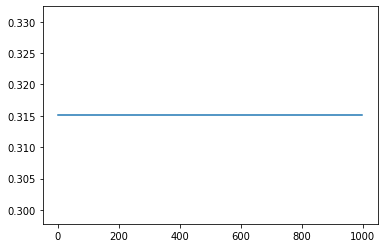

In [26]:
plt.plot(distribution[0,:])

In [28]:
distribution[0, :10]

array([0.3151247, 0.3151247, 0.3151247, 0.3151247, 0.3151247, 0.3151247,
       0.3151247, 0.3151247, 0.3151247, 0.3151247])

In [21]:
n_pos = 1000
n_total = 17000
n_models = 10
n_drawings = 1000

result = stats.binom.rvs(1, n_pos/n_total, size=(n_total, n_models, n_drawings))

In [22]:
result_per_drawing = result.sum(axis=1)

In [26]:
unique, counts = np.unique(result_per_drawing[:,0], return_counts=True)
plt.plot(unique[1:], counts[1:])

NameError: name 'plt' is not defined

In [25]:
result_per_drawing.shape

(17000, 1000)

In [27]:
unique, counts = np.unique(result_per_drawing[:,0], return_counts=True)
#plt.plot(unique[1:], counts[1:])

In [28]:
unique, counts = zip(*[np.unique(result_per_drawing[:,i], return_counts=True) for i in range(result_per_drawing.shape[1])])

In [29]:
max = 0

for values in unique:
    if len(values) > max:
        max = len(values)

b=[]

for i in range(len(counts)):
    if len(counts[i]) != max:
        b.append(np.pad(counts[i], (0,max-len(counts[i])), 'constant', constant_values = 0))
    else:
        b.append(counts[i])
        
b = np.array(b)

(array([  6.,  15.,  62., 152., 213., 204., 204.,  89.,  43.,  12.]),
 array([221. , 230.5, 240. , 249.5, 259. , 268.5, 278. , 287.5, 297. ,
        306.5, 316. ]),
 <BarContainer object of 10 artists>)

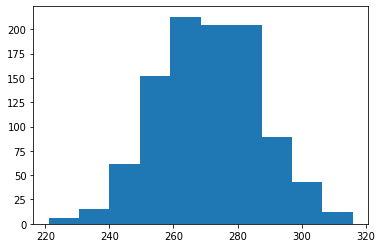

In [30]:
import matplotlib.pyplot as plt
plt.hist(b[:,3])

In [32]:
b.mean(axis=0)

array([9.272433e+03, 5.791969e+03, 1.632776e+03, 2.708090e+02,
       2.970000e+01, 2.202000e+00, 1.110000e-01])

In [139]:
stats.normaltest(b, axis=0)

NormaltestResult(statistic=array([5.31867678e+00, 3.10957384e+00, 2.62155059e+00, 4.21035344e-01,
       4.05306913e+00, 1.11104625e+02, 5.59677541e+02]), pvalue=array([6.99945156e-002, 2.11234387e-001, 2.69610947e-001, 8.10164738e-001,
       1.31791446e-001, 7.48061359e-025, 2.93471620e-122]))

In [132]:
b

array([[9299, 5758, 1643, ...,   26,    3,    0],
       [9184, 5828, 1663, ...,   32,    3,    1],
       [9310, 5753, 1632, ...,   19,    1,    0],
       ...,
       [9335, 5816, 1565, ...,   31,    2,    0],
       [9349, 5735, 1607, ...,   37,    2,    0],
       [9261, 5905, 1555, ...,   32,    1,    0]])